In [14]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [26]:
def compute_l_p_m(N, lower_bound, upper_bound):
    """
    Compute:
      l(n,k) = number of (N-n)-step paths starting at X_n=k that stay within bounds
      p(n,k) = l(n+1,k+1) / l(n,k)
      m(n,k) = max(k, p(n,k) * m(n+1,k+1) + (1-p(n,k)) * m(n+1,k-1))
    Returns dictionaries: l, p, m, valid_ks
    """
    l = defaultdict(int)
    p = dict()
    m = dict()
    valid_ks = dict()

    for n in range(0, N+1):
        lo = int(lower_bound(n))
        hi = int(upper_bound(n))
        valid_ks[n] = list(range(lo, hi+1))

    for k in valid_ks[N]:
        l[(N,k)] = 1

    for n in range(N-1, -1, -1):
        for k in valid_ks[n]:
            val = 0
            if (k+1) in valid_ks[n+1]:
                val += l[(n+1, k+1)]
            if (k-1) in valid_ks[n+1]:
                val += l[(n+1, k-1)]
            l[(n,k)] = val

    for n in range(0, N):
        for k in valid_ks[n]:
            denom = l[(n,k)]
            if denom > 0:
                numer = l.get((n+1, k+1), 0)
                p[(n,k)] = numer / denom
            else:
                p[(n,k)] = 0.0

    for k in valid_ks[N]:
        m[(N,k)] = k

    for n in range(N-1, -1, -1):
        for k in valid_ks[n]:
            prob = p.get((n,k), 0.0)
            m_up = m.get((n+1, k+1), k+1)
            m_down = m.get((n+1, k-1), k-1)
            candidate = prob * m_up + (1 - prob) * m_down
            m[(n,k)] = max(k, candidate)

    return m, valid_ks


In [27]:
N = 6
lower_bound = lambda x : - 2 - 0 * x
upper_bound = lambda x : 2 + 0 * x

In [28]:
m, valid = compute_l_p_m(6, lower_bound, upper_bound)

In [29]:
real_valid = valid.copy()
for k in valid[0]:
    real_valid[0][k] = 0
real_valid[0][0] = 1

for n in range(1, N+1):
    for k in valid[n]:
        real_valid[n][k] = 0
        if k - 1 in valid[n - 1]:
            real_valid[n][k] = max(real_valid[n][k], real_valid[n - 1][k - 1])
        if k + 1 in valid[n - 1]:
            real_valid[n][k] = max(real_valid[n][k], real_valid[n - 1][k + 1])


In [ ]:
real_valid = valid.copy()
for k in valid[0]:
    real_valid[0][k] = 0
real_valid[0][0] = 1

for n in range(1, N+1):
    for k in valid[n]:
        real_valid[n][k] = 0
        if k - 1 in valid[n - 1]:
            real_valid[n][k] = max(real_valid[n][k], real_valid[n - 1][k - 1])
        if k + 1 in valid[n - 1]:
            real_valid[n][k] = max(real_valid[n][k], real_valid[n - 1][k + 1])
            
def reachable_from_zero(n, k):
    return real_valid[n][k]

1 1
2 2
3 1
4 0
4 2
5 -1
5 1
6 -2
6 0
6 2


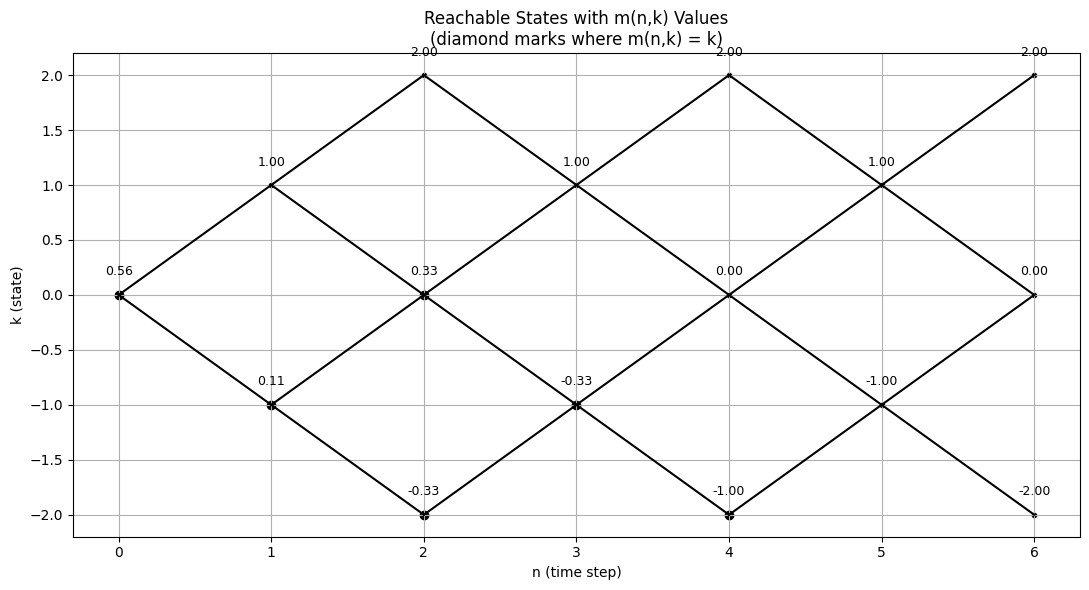

In [ ]:
# ------------------------------------------------------
# PARAMETERS
# ------------------------------------------------------
N = 6
lower_bound  = lambda n: -2
upper_bound  = lambda n:  2

# ------------------------------------------------------
# COMPUTE l(n,k), p(n,k), m(n,k)
# ------------------------------------------------------
def compute_l_p_m(N, lower_bound, upper_bound):
    l = defaultdict(int)
    p = {}
    m = {}
    valid = {}

    # Valid k values at each n based on bounds
    for n in range(N+1):
        lo = int(lower_bound(n))
        hi = int(upper_bound(n))
        valid[n] = list(range(lo, hi+1))

    # Terminal condition for l
    for k in valid[N]:
        l[(N,k)] = 1

    # Compute l backwards
    for n in range(N-1, -1, -1):
        for k in valid[n]:
            l[(n,k)] = l.get((n+1, k+1), 0) + l.get((n+1, k-1), 0)

    # Compute p
    for n in range(N):
        for k in valid[n]:
            denom = l[(n,k)]
            if denom == 0:
                p[(n,k)] = 0
            else:
                p[(n,k)] = l.get((n+1, k+1), 0) / denom

    # Terminal condition for m
    for k in valid[N]:
        m[(N,k)] = k

    # Compute m backwards
    for n in range(N-1, -1, -1):
        for k in valid[n]:
            pu = p[(n,k)]
            m_next = pu * m.get((n+1, k+1), k+1) + (1 - pu) * m.get((n+1, k-1), k-1)
            m[(n,k)] = max(k, m_next)

    return l, p, m, valid


l, p, m, valid = compute_l_p_m(N, lower_bound, upper_bound)

# ------------------------------------------------------
# DETERMINE REACHABLE STATES
# ------------------------------------------------------
real_valid = {n: {} for n in range(N+1)}

# Only k = 0 reachable at n = 0
for k in valid[0]:
    real_valid[0][k] = 0
real_valid[0][0] = 1

# Forward dynamic reachability
for n in range(1, N+1):
    for k in valid[n]:
        real_valid[n][k] = 0
        if (k-1) in valid[n-1] and real_valid[n-1].get(k-1, 0):
            real_valid[n][k] = 1
        if (k+1) in valid[n-1] and real_valid[n-1].get(k+1, 0):
            real_valid[n][k] = 1

def reachable_from_zero(n, k):
    return real_valid[n].get(k, 0) == 1


# ------------------------------------------------------
# PLOT
# ------------------------------------------------------
plt.figure(figsize=(11,6))
ax = plt.gca()

# Draw all edges (same color)
for n in range(N):
    for k in valid[n]:
        if not reachable_from_zero(n, k):
            continue
        # connect to k+1
        if reachable_from_zero(n+1, k+1):
            ax.plot([n, n+1], [k, k+1], color="black")
        # connect to k-1
        if reachable_from_zero(n+1, k-1):
            ax.plot([n, n+1], [k, k-1], color="black")

# Draw nodes + labels
for n in range(N+1):
    for k in valid[n]:
        if not reachable_from_zero(n, k):
            continue
        value = m[(n,k)]
        is_hit = abs(value - k) < 1e-12  # m(n,k) = k

        # Diamond for m(n,k) = k, circle otherwise
        ax.scatter(n, k, marker=("." if is_hit else "o"), color="black")

        # Slight text shift upward
        ax.text(n, k + 0.15, f"{value:.2f}",
                ha='center', va='bottom', fontsize=9)

ax.set_xlabel("n (time step)")
ax.set_ylabel("k (state)")
ax.set_title("Reachable States with m(n,k) Values\n(diamond marks where m(n,k) = k)")
ax.grid(True)

plt.tight_layout()
plt.show()


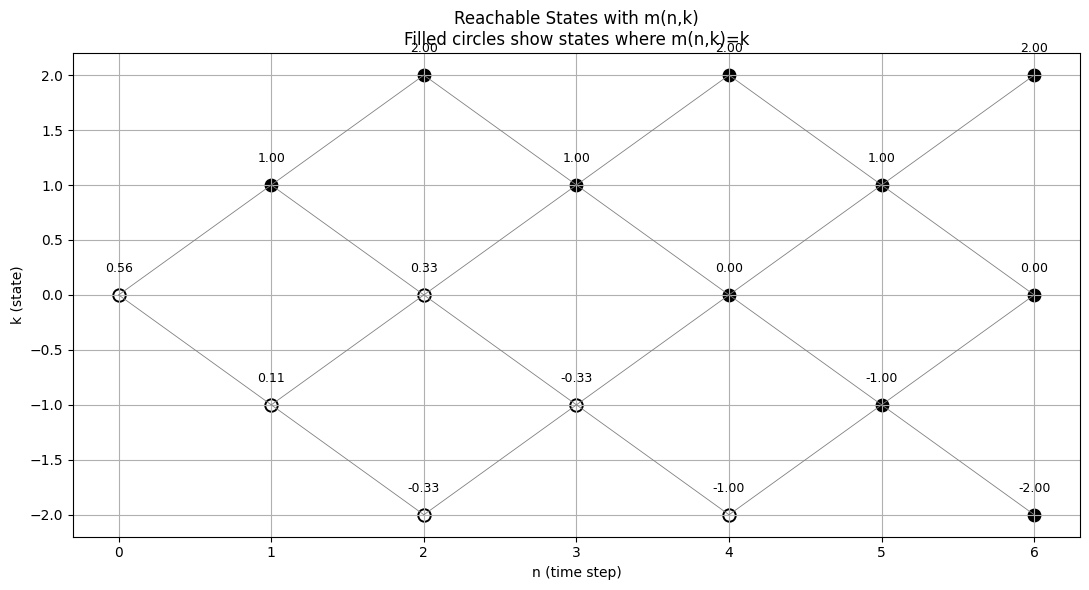

In [38]:
# ------------------------------------------------------
# PLOT WITH IMPROVED READABILITY
# ------------------------------------------------------
plt.figure(figsize=(11,6))
ax = plt.gca()

# Thinner, light gray edges
for n in range(N):
    for k in valid[n]:
        if not reachable_from_zero(n, k):
            continue
        if reachable_from_zero(n+1, k+1):
            ax.plot([n, n+1], [k, k+1], color="gray", linewidth=0.6)
        if reachable_from_zero(n+1, k-1):
            ax.plot([n, n+1], [k, k-1], color="gray", linewidth=0.6)

# Distinct node styles
for n in range(N+1):
    for k in valid[n]:
        if not reachable_from_zero(n, k):
            continue

        value = m[(n,k)]
        is_hit = abs(value - k) < 1e-12

        if is_hit:
            # Filled black circle
            ax.scatter(n, k, s=80, color="black")
        else:
            # Hollow circle
            ax.scatter(n, k, s=80, facecolors="white", edgecolors="black", linewidth=1.4)

        # Shifted label
        ax.text(n, k + 0.18, f"{value:.2f}",
                ha='center', va='bottom', fontsize=9)

ax.set_xlabel("n (time step)")
ax.set_ylabel("k (state)")
ax.set_title("Reachable States with m(n,k)\nFilled circles show states where m(n,k)=k")
ax.grid(True)

plt.tight_layout()
plt.show()